In [116]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas 
import seaborn as sns

In [117]:
# constraints of working in our work cell 
# these are the plates we have 

class Well():
    '''
    A well class
    '''
    def __init__( self, index, vol ):
        self.index = index # 0-index in plate 
        self.vol = vol # in microliters 
        

class Plate():
    '''
    A plate class 
    '''   
    
    def __init__( self, ptype ):
        
        self.ptype = ptype 
        self.well_count = available_ptypes[ self.ptype ]
        self.wells = [ Well(n, 0) for n in range( well_count )]    
    
    def __iter__( self ):
        return iter(self.wells)
    
    def well( self, well_index ):
        '''
        Selects a well by index
        '''
        
        if well_index < len(self.wells):
            return self.wells[ well_index ]
        
    
    
    def __repr__( self ):
        '''
        Displays 
        
        plate_type( wells_filled/wells )
        '''
        #filled_wells = [ w.index for w in self.wells if w.vol > 0.0 ]
        fmt_str = ( self.ptype, len(self.wells), self.well_count )
        return '{} ({}/{})'.format( *fmt_str )
    
# instruments 
class PlateStack():
    '''
    A plate stack
    '''
    
    def load_plate( self, pt ):
        '''
        Loads a single plate in LIFO order
        '''
        self.plates.append( pt )

    def select_plate( self ):
        '''
        For sequential access to single plates at a time 
        '''
        return self.plates.pop()

    def __init__( self ):
    
        self.plates = []
        
        
class Peeler():
    def peel( self ):
        pass
    
class Sealer():
    def seal( self ):
        pass
    
class Echo():
    '''
    Labcyte Echo acoustic liquid handler
    '''
    def load_dest( self, pt ):
        self.dest_plate = pt 
        print( 'Loaded "{}" as destination'.format(pt) )
        
    def load_source( self, pt ):
        self.source_plate = pt
        print( 'Loaded "{}" as source'.format(pt) )
        
    def unload_source( self ):
        print( 'Unloaded "{}" as source'.format(self.source_plate) )
        self.source_plate = None 
        
    def unload_dest( self ):
        print( 'Unloaded destination plate'.format(self.source_plate) )
        self.dest_plate = None
    
    def transfer_set( self, xfer_set ):
        '''
        Expects a Pandas DataFrame object with colums ...
        '''
        
        for source_well, dest_well, vol in xfer_set:
            self.source_plate.well(source_well).vol -= vol
            self.dest_plate.well(dest_well).vol += vol
        
    def __init__( self ):
        self.source_plate = None
        self.dest_plate = None 
        
        
class Arm():
    def move( self, pt, source, dest ):
        fmt_str = ( pt, source, dest )
        #print( 'Moving plate "{}" from "{}" to "{}"'.format(*fmt_str))
        
        
class AlreadyPlateHere( Exception ):
    pass 

class Dispenser():
    
    def __init__( self ):
        self.loaded_plate = None 
    
    def dispense( self, reagent, volume, well_indexes ):
        fmt_str = ( volume, reagent, len(well_indexes) )
        print( 'Dispensed {} µL of {} to {} wells'.format( *fmt_str ))
        pass 
    
    def load_plate( self, pt ):
        if self.loaded_plate == None:
            self.loaded_plate = pt 
        else: 
            raise AlreadyPlateHere( "sealer" )
        
    def unload_plate( self ):
        self.loaded_plate = None 
    
class Bravo():
    def thermal_cycle( self, pt, program ):
        pass 
    
class ColdStorage:
    pass

In [118]:
# Neat work cell 

# instruments we have 
plate_stack_A = PlateStack()
plate_stack_B = PlateStack()
peeler = Peeler()
echo = Echo()
arm = Arm()
sealer = Sealer()
dispenser = Dispenser()
bravo = Bravo()
cold_storage = ColdStorage()

In [119]:
# primers we have 
primers_available = [
    #( 't7', 'sequence', 'plate_stack_A__plate_0' ), 
    #( 't7term', 'sequence', 'plate_stack_A__plate_45' ), 
    't7', 
    't7term', 
]

available_ptypes = dict([
    ( '384-pcr', 384 ), # well count
    ( '1536-pcr', 1536 )
])

# reagents we have 
reagents_available = [
    'water', 
    'DMSO', 
    'master_mix', 
]

In [120]:
# simulation params! 
plates_min_max = ( 1, 50 )     # plates per simulation cycle 
samples_min_max = ( 10, 384 ) # samples per plate (different for each)

In [121]:
# simulate scanning in customer orders 
# assume you are reading down the plate stack 
# top, second from top, .... second from bottom, bottom 
# is the order 

customer_plates = []
sample_data = []

for n in range( np.random.randint( *plates_min_max ) ):
    pt = Plate( '384-pcr' )
    for s in range( np.random.randint( *samples_min_max ) ):
        primer_1 = np.random.choice( primers_available ) 
        primer_2 = np.random.choice( primers_available ) 
        pt.wells.append( Well(s, 10) )
        
        # add in sample data 
        sample_pkg = ( n, s, primer_1, primer_2 ) 
        sample_data.append( sample_pkg ) 
        
    # add plate to stack 
    customer_plates.append(pt) 
    plate_stack_A.load_plate(pt)
        
# orders have been placed in the stack 
# simulate daily setup tasks 
# fill plate_stack_B with empty 1536-well plates
for n in range( 30 ):
    plate_stack_B.load_plate(Plate('1536-pcr'))
    
# load the dispenser 

# customer data dashboard 
print( 'Today is Monday, April 10' )
print( 'Received {} customer plates'.format(len(plate_stack_A.plates)))

NameError: name 'well_count' is not defined

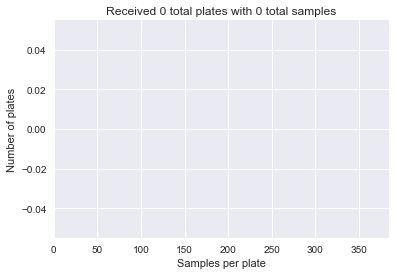

In [109]:
samples_n = [ len(pt.wells) for pt in customer_plates ] 
plt.hist(samples_n)
plt.xlim( 0, 384 ) 
plt.xlabel( 'Samples per plate' ) 
plt.ylabel( 'Number of plates' ) 
fmt_str = ( len( customer_plates ), sum(samples_n) )
plt.title( 'Received {} total plates with {} total samples'.format(*fmt_str) )
plt.show()

In [110]:
# let's make the LH instructions now 
cols = [ 'plate_id', 'well_id', 'primer_1', 'primer_2' ]
samples = pandas.DataFrame( sample_data, columns=cols )
samples[ 'dest_plate_id' ] = samples.index // 1536
samples[ 'dest_well_id' ] = samples.index % 1536
samples.sample( 3 ) 

TypeError: cannot perform __floordiv__ with this index type: <class 'pandas.indexes.base.Index'>

In [111]:
prices = {
    '1536-pcr': 15.00, 
    '384-pcr': 5.00, 
    'seal': 1.00,
}

cost = 0.0

In [112]:
# now, dest plate statistics! 

fee1 = len(samples)*0.50 # $0.50 per sample model 
fee2 = len(customer_plates)*150 # $150 per plate model 
print( 'REVENUES' ) 
print( 'We have charged ${:2.2f} ($0.50/sample)'.format( fee1 ) )
print( 'We have charged ${:2.2f} ($150/plate)'.format( fee2 ) )

REVENUES
We have charged $0.00 ($0.50/sample)
We have charged $0.00 ($150/plate)


In [113]:
n_pcr = len( samples.dest_plate_id.unique() )
print( 'We will need {} PCR plates (1536-well) today'.format( n_pcr ) )
cost += n_pcr * prices[ '1536-pcr' ]
print( '\nCOSTS\n${:2.2f}'.format( cost ) )

AttributeError: 'DataFrame' object has no attribute 'dest_plate_id'

In [114]:
# now we'll get into the actual protocol 

In [115]:
for idx, pcr_samples in samples.groupby( 'dest_plate_id' ):
    
    pcr_samples_so_far = 0 

    # get an empty 1536-well plate 
    dest = plate_stack_B.select_plate()
    arm.move( dest, plate_stack_B, echo ) 
    echo.load_dest( dest ) 
    
    print( 'PCR', idx, 'will include customer plates', pcr_samples.plate_id.unique() )
    
    for plate_id, customer_plate_samples in pcr_samples.groupby( 'plate_id' ): 
        
        # iterates over all the customer plates
        # that are supposed to go in this PCR plate 
        
        # first plate to work with 
        pt = plate_stack_A.select_plate() # it must be the one we want
        arm.move( pt, plate_stack_A, peeler )
        peeler.peel()
        arm.move( pt, peeler, echo ) 
        echo.load_source( pt ) 
        xfer_set = []
        for idx, row in customer_plate_samples.iterrows():
            xfer_set.append(( row.well_id, row.dest_well_id, 0.005 ))
        echo.transfer_set( xfer_set ) 
        echo.unload_source()
        arm.move( pt, echo, sealer ) 
        sealer.seal()
        
        pcr_samples_so_far += len(pt.wells)
        
        # hmm, we need to figure out where it goes now  
        store = len( pt.wells ) == len( customer_plate_samples ) 
        if pcr_samples_so_far < 1536 and store:
            arm.move( pt, sealer, cold_storage ) 
        else:
            arm.move( pt, sealer, plate_stack_A ) 
            plate_stack_A.load_plate( pt ) 
            
    # now that we are back down to one plate, dispense 
    echo.unload_dest()
    arm.move( dest, echo, dispenser ) 
    wells_need_mix = [ well.index for well in dest ]
    print( wells_need_mix ) 
    dispenser.dispense( 0.250, 'master_mix', wells_need_mix ) 
    dispenser.dispense( 0.250, 'water', wells_need_mix ) 
    arm.move( dest, dispenser, sealer )
    sealer.seal()
    arm.move( dest, sealer, bravo )
    program = []
    bravo.thermal_cycle( dest, program ) 

KeyError: 'dest_plate_id'